In [1]:
import cv2
import os
import numpy as np
from matplotlib import pyplot as plt
import pyautogui
import mss
from scipy.spatial import distance
import time


DEBUG = False

claimable_tiles_list = []
to_claim_list = []


#print(os.listdir("./img/"))

class Tile:
    def __init__(self, name="", filename="", hsv_lower_thres=(0,0,0), hsv_upper_thres=(255,255,255), threshold=0.5, template=[], centres=[]):
        self.name = name
        self.filename = filename
        self.hsv_lower_thres = hsv_lower_thres
        self.hsv_upper_thres = hsv_upper_thres
        self.threshold = threshold
        self.template = template
        self.centres = centres

class ScreenCapture:
    def __init__(self, offset_left=0, offset_top=0, width=320, height=240, bgr=[]):
        self.offset_left = offset_left
        self.offset_top = offset_top
        self.width = width
        self.height = height
        self.bgr = bgr

class ClickLocation:
    def __init__(self, point=(100,100), button='left'):
        self.point = point
        self.button = button
        

orange_hsv_lower_threshold = (9,44,255)
orange_hsv_upper_threshold = (11,255,255)

tiles = [] #list of tiles for easy iteration

#each instance of Tile is named so it can be easily referred to
safe = Tile('safe', 'safe.PNG', orange_hsv_lower_threshold, orange_hsv_upper_threshold, 0.7)
tiles.append(safe)

one = Tile('one', '1.PNG', (0,0,0), (179,255,250), 0.60)
tiles.append(one)

two = Tile('two', '2.PNG', (0,0,0), (179,255,245), 0.65)
tiles.append(two)

three = Tile('three', '3.PNG', (0,0,0), (179,255,245), 0.65)
tiles.append(three)

flag = Tile('flag', 'flag.PNG', (0,0,0), (179,255,250), 0.6)
tiles.append(flag)

claimable_grey = Tile('claimable_grey','claimable.PNG', (0,0,0), (179,255,70), 0.7)
tiles.append(claimable_grey)

claimable_coloured = Tile('claimable_coloured','claimable.PNG', (0,0,0), (179,255,170), 0.60)
tiles.append(claimable_coloured)

# load the templates for each tile type
for t in tiles:
    t.template = cv2.imread('./img/' + t.filename,0)

In [2]:

if DEBUG:  #display assets and properties
    for t in tiles:
        #for s in t:
            print(t.name)
            print(t.filename)
            print(t.hsv_lower_thres)
            print(t.hsv_upper_thres)
            print(t.threshold)
            print('h:',end="")
            print(t.template.shape[0])
            print('w:', end="")
            print(t.template.shape[1])

            plt.subplot(121),plt.imshow(t.template)
            plt.title(t.name)
            plt.show()


In [3]:
# Calculate cell promity threshold for checking adjacency
tile_proximity_threshold = distance.euclidean((0,0), claimable_grey.template.shape)

#allow for some positional error
tile_proximity_threshold = int(tile_proximity_threshold * 1.2)

print(tile_proximity_threshold)

36


In [4]:
#screen capture
# start of code to capture desktop screenshot

frame = ScreenCapture(65, 75, 1085, 615)

print(frame.offset_left)
print(frame.offset_top)

65
75


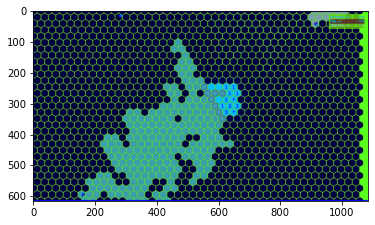

In [5]:
def read_screen(left, top, width, height):
    with mss.mss() as sct:
        # The screen part to capture 
        monitor = {"top": frame.offset_top, "left": frame.offset_left, "width": frame.width, "height": frame.height}

        # Get raw pixels from the screen, save it to a Numpy array
        image = np.array(sct.grab(monitor))
    return(image)

frame.bgr = read_screen(frame.offset_left, frame.offset_top, frame.width, frame.height)
frame.hsv = cv2.cvtColor(frame.bgr, cv2.COLOR_BGR2HSV)
frame.rgb = cv2.cvtColor(frame.bgr, cv2.COLOR_BGR2RGB)

# Display the picture
plt.imshow(frame.hsv)

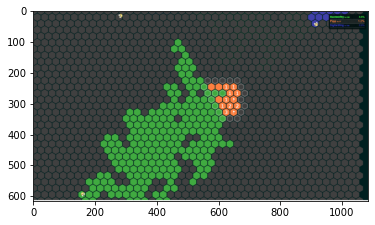

In [6]:
plt.imshow(frame.rgb)

In [7]:
###########################################################################################
def make_hsv_mask_from_bgr(bgr, lower_hsv, higher_hsv):
     
  #  print(low_thres)
  #  print(high_thres)
  #  lower_hsv = np.array(lower_thres)
  #  higher_hsv = np.array(higher_thres)
    
    hsv = cv2.cvtColor(bgr, cv2.COLOR_BGR2HSV)
    mask = cv2.inRange(hsv, lower_hsv, higher_hsv)
    return(mask)
###########################################################################################

#hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
#mask = cv2.inRange(hsv, lower_hsv, higher_hsv)

#plt.imshow(mask)
#print("Orange Mask")    

# for experiementing with arrays and lists
from scipy.spatial import distance

###################################################################################
#function accepting dense array that checks for close points and generates
#a sparse list without overlap if the template were placed at each point
def make_sparse(dense, template):    
    sparse = []
    
    # distance threshold
    template_diagonal = distance.euclidean((0,0),template.shape)
    distance_thres = template_diagonal / 2
    
    for pt in dense:
        closest = distance_thres + 1 #initialise
        
        for p in sparse:
            result = distance.euclidean(pt,p)
            if result < distance_thres:
                closest = result
        
        if closest > distance_thres: # if all points in new list are 'distant'
            sparse.append(pt)
    
    if DEBUG == True:
        print(sparse)
        print("Items : ", end="") 
        print(len(sparse), end="")
        print("/", end="")
        print(len(dense))
    return(sparse)
##################################################################################


##############################################################################
def make_centre_list_from_mask(mask, template, threshold = 0.80):

    dense_list = []

    res = cv2.matchTemplate(mask,template,cv2.TM_CCOEFF_NORMED)
    locations = np.where( res >= threshold)
    
    h = t.template.shape[0]
    w = t.template.shape[1]

    #halve to get offset to centres
    h = int(h/2)
    w = int(w/2)

    for pt in zip(*locations[::-1]):
        dense_list.append((pt[0] + w, pt[1] + h))
    
    sparse_list = make_sparse(dense_list, template)
    
    return(sparse_list)
################################################################################



###############################################################################
# Takes a rgb image list of points of centres of a template
# Returns the image with rectangles around each template
def annotate_centres(rgb, template, lst):
    img = rgb.copy()
    h, w = template.shape[0:2]
    
    for pt in lst:
        i = (pt[0] - int(w/2), pt[1] - int(h/2)) # top left of rectangle
        j = (pt[0] + int(w/2), pt[1] + int(h/2)) # bottom right of rectangle
        cv2.rectangle(img, i, j, (0,255,0), 3)

    return(img)

# Example: plt.imshow(plot_locations(frame_rgb, tile_safe, safe_tiles_list))
################################################################################


plt.rcParams["figure.figsize"] = (20, 5)  # change plt plot sizes

# generate masks for each template with optimised thresholds
# and then run 2D correlation for matches and threshold
for t in tiles:
    t.mask = cv2.inRange(frame.hsv, t.hsv_lower_thres, t.hsv_upper_thres) # create mask from hsv
    t.centres = make_centre_list_from_mask(t.mask, t.template, t.threshold) # template match locations
    
    if DEBUG: # plots the template, image mask and resulting locations of template matches on image
        #plot results
        plt.subplot(131), plt.imshow(t.template)
        plt.title(t.name)

        plt.subplot(132), plt.imshow(t.mask)

        plt.subplot(133), plt.imshow(annotate_centres(frame.rgb, t.template, t.centres))
        plt.title(len(t.centres))
        plt.show()
    

In [8]:
# list of cells that can be claimed - unknown if safe or trapped

claimable_tiles_list.clear()

claimable_tiles_list.extend(claimable_grey.centres) # claimable grey
claimable_tiles_list.extend(claimable_coloured.centres) # claimable coloured

print(claimable_tiles_list)


[(566, 224), (590, 224), (614, 224), (638, 224), (662, 224), (674, 245), (685, 266), (674, 286), (685, 307), (674, 327), (637, 348), (661, 348), (553, 245), (566, 265), (590, 265), (614, 265), (577, 286), (590, 306), (601, 327), (614, 347)]


In [9]:
########################################################################################
#returns true if a cell on the test list is adjacent 
# calculates the distance to each test cell and returns true on the first adjacent cell
def is_adjacent_cell(cell, to_test, threshold):

    result = False
    
#    template_diagonal = distance.euclidean((0,0), template.shape)
    max_d = threshold

    # print(cell)
    # print("Threshold ",end="")
    # print(threshold)
    
    for pts in to_test: 
        d = distance.euclidean(cell,pts) 
      #  print(pts, end="")
      #  print(" ",end="")
      #  print(d)
        
        if d < threshold: 
            result = True
            break 
    
    return(result)
###########################################################################################

###########################################################################################
# Checks two lists of points for adjacent points
# If cells from first list(subjects) are adjacent to any in the test list
# ie. distance < diagonal of template + 20%, 
# then they are added to the returned list 

def check_list_for_adjacency(subject_list, test_list, threshold):
    from scipy.spatial import distance
    import math

    _locations = [] 

    for cell in subject_list: 
        if is_adjacent_cell(cell, test_list, threshold):
            _locations.append(cell)
    
    return(_locations)

# Example: 
#  safe_claimable_location_list = check_list_for_adjacency(claimable_tiles_list, safe_tiles_list) 
###########################################################################################


In [10]:
########################################################################################
#returns the number of cells in the to_test list adjacent to the centre cell 
# calculates the distance to each test_cell centre and thresholds
def tally_adjacents(cell, to_test_list, distance_threshold):

    result = 0
    
    for pts in to_test_list: 
        d = distance.euclidean(cell,pts) 
        
        if d < distance_threshold: 
            result = result + 1
    
    return(result)
###########################################################################################


# Identify cells that state indicate adjacent cells are safe

###########################################################################################
# Returns list of safe status cells
# Called after generation of masks and templates are matched
def make_safe_status_list():

    # List for collating 'safe status' cells
    _safe_list = []

    # from safe cells - ALL are safe!
    _safe_list.extend(safe.centres)
    
    # safe from ones next to a flag
    if DEBUG:
        print(one.centres)
        print(len(one.centres))

    safe_ones = check_list_for_adjacency(one.centres, flag.centres, tile_proximity_threshold)
    _safe_list.extend(safe_ones)

    if DEBUG:
        print("Safe ", end="")
        print(safe_ones)

    _safe_list.extend(safe_ones)
    
    # safe from twos next to two flags
    if DEBUG:
        print(two.centres)
        print(len(two.centres))

    safe_twos = []

    for p in two.centres:
        #print(p)
        j = tally_adjacents(p, flag.centres, tile_proximity_threshold)
        #print(j)
        if j == 2:
            safe_twos.append(p)

    if DEBUG:
        print("Safe ", end="")
        print(safe_twos)

    _safe_list.extend(safe_twos)
    
    # safe from threes next to three flags
    if DEBUG:
        print(three.centres)
        print(len(three.centres))

    safe_threes = []

    for p in three.centres:
        #print(p)
        tally = tally_adjacents(p, flag.centres, tile_proximity_threshold)
        #print(tally)
        if tally == 3:
            safe_threes.append(p)

    if DEBUG:
        print("Safe ", end="")
        print(safe_threes)

    _safe_list.extend(safe_threes)
    
    #rationalise list in case of duplicates
    _safe_list = make_sparse(_safe_list, claimable_grey.template)
    
    return(_safe_list)

############################################################################################
    
# List for collating 'safe status' cells
safe_list = []

# from safe cells - ALL are safe!
safe_list.extend(safe.centres)


In [11]:
# safe from ones next to a flag
print(one.centres)
print(len(one.centres))

safe_ones = check_list_for_adjacency(one.centres, flag.centres, tile_proximity_threshold)
safe_list.extend(safe_ones)

print("Safe ", end="")
print(safe_ones)

safe_list.extend(safe_ones)

[(626, 245), (650, 245), (637, 266), (661, 266), (626, 286), (613, 307)]
6
Safe [(637, 266), (661, 266), (626, 286)]


In [12]:
# safe from twos next to two flags
print(two.centres)
print(len(two.centres))

safe_twos = []

for p in two.centres:
    #print(p)
    j = tally_adjacents(p, flag.centres, tile_proximity_threshold)
    #print(j)
    if j == 2:
        safe_twos.append(p)

print("Safe ", end="")
print(safe_twos)

safe_list.extend(safe_twos)

[(637, 308), (661, 308)]
2
Safe [(637, 308), (661, 308)]


In [13]:
# safe from threes next to three flags
print(three.centres)
print(len(three.centres))

safe_threes = []

for p in three.centres:
    #print(p)
    tally = tally_adjacents(p, flag.centres, tile_proximity_threshold)
    #print(tally)
    if tally == 3:
        safe_threes.append(p)

print("Safe ", end="")
print(safe_threes)

safe_list.extend(safe_threes)

[(625, 328)]
1
Safe []


In [14]:
#rationalise the safe_status list of cells
safe_list = make_sparse(safe_list, claimable_grey.template)

# generate list of untrapped cells adjacent to 'safe' cells from claimable cell list
untrapped_cells = check_list_for_adjacency(claimable_tiles_list, safe_list, tile_proximity_threshold)

print(untrapped_cells)

[(566, 224), (590, 224), (614, 224), (674, 245), (685, 266), (674, 286), (685, 307), (674, 327), (553, 245), (566, 265), (590, 265), (614, 265), (577, 286), (590, 306)]


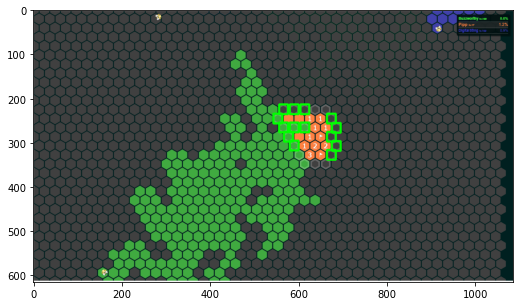

In [15]:
# sanity check image of untrapped cells to be mouse left-clicked
plt.imshow(annotate_centres(frame.rgb, claimable_grey.template, untrapped_cells))

In [16]:
##############################################################################################
# Convert image/mask relative points to absolute screen positions
# Required pre-processing for click routines to account for capture offsets

def convert_to_screen_absolute(_lst, _ox, _oy):
    
    screen_pos = []

    #translate list to absolute screen positions
    for cell in _lst:   
        screen_pos.append((cell[0] + _ox, cell[1] + _oy))
    
    if DEBUG:
        print(screen_pos)
    return(screen_pos)

##############################################################################################


In [17]:
##############################################################################################
# Function to left click centres of supplied tile locations
# allowing for screen capture offsets and template size

import pyautogui

def click_list(lst, ox, oy, btn, time = 0.25):
    
    if DEBUG:
        print(lst)
        print(ox, oy)
        print(btn)
        
    screen_pos = []
    
    #translate list to absolute screen positions
    screen_pos = convert_to_screen_absolute(lst, ox, oy)
    
    #click each location
    for cell in screen_pos:
        pyautogui.click(cell[0], cell[1], button=btn, duration = time)
    
    return
###############################################################################################


#print(untrapped_cells)


#click_list(untrapped_cells, frame.offset_left, frame.offset_top, 'left', 0.25)


#read current mouse position
print(pyautogui.position())


Point(x=805, y=-1675)


In [18]:
########################################################################################
# Function calculates the nearest point in the list from the mouse
# Accepts LR_click_list: lr_click_list.append((pt, btn))
# where pt is (x,y) and btn is the mouse button to click
#
# Upon clicking the item is removed from the list and the list returned
# ######################################################################################
def click_nearest(_lst, delay):
    
    #print(lst)
    
    #read current mouse position
    mouse_location = pyautogui.position()

    from scipy.spatial import distance

    dist =[]

    #calculate distance to each location in list
    for index, pt in enumerate(_lst):
        d = distance.euclidean(mouse_location,pt.point)
        #print(index, pt.point, d)
        dist.append(d)

    #find index of closest item 
    index_min = np.argmin(dist)

    #print("Minimum", dist[index_min],"at index", index_min, _lst[index_min].point, _lst[index_min].button)
    
    #remove and click it
    item = _lst.pop(index_min)
    
    #unpack
    x = item.point[0]
    y = item.point[1]
    btn = item.button

    #print(x, y, btn)
    pyautogui.click(x, y, button=btn, duration = delay)

    return(_lst)

##########################################################################################

#pyautogui.moveTo(100,200)
#click_nearest(untrapped_cells, frame.offset_left, frame.offset_top, 'left', 0.25)

# for testing as the click routine removes items after clicking them


lst = untrapped_cells.copy()

if DEBUG:
    print("Inital list:", len(lst))
    print(lst)

# convert image co-ordinates to screen co-ords
lst = convert_to_screen_absolute(lst, frame.offset_left, frame.offset_top)

# assign as left click co-ords and change name of list to:
lr_click_list = []
for pt in lst:
    lr_click_list.append(ClickLocation(pt,'left'))

if DEBUG: # display new list of ClickLocation objects
    print("New list of ClickLocations:", len(lr_click_list))
    for pt in lr_click_list:
        print(pt.point, pt.button)

# click all untrapped cells
while len(lr_click_list) > 0:
    lr_click_list = click_nearest(lr_click_list, 0.5)

if DEBUG: # display resulting list
    print("Returned list:", len(lr_click_list))
    for i, pt in enumerate(lr_click_list): 
        print(i, pt.point, pt.button)

